# The Dataset

We used this dataset for our miniproject: https://www.kaggle.com/datasets/puneet6060/intel-image-classification

The dataset contains 6 classes of images: `building`, `forest`, `glacier`, `mountain`, `sea`, and `street`. We decided to delete the class `street` and it's corresponding pictures to simplify the learning process. The images are divided into folders with their respective labels. We used the `image_dataset_from_directory` method of Keras to convert the images into a TensorFlow dataset object for training.

## Importing the Data

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras

In [26]:
training_img_path = "./dataset/seg_train/seg_train/"

img_size = 150
batch_size = 32
seed = 42   # the seed will make sure the two datasets are not overlapping

train_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode='int',
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    training_img_path,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode='int',
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=batch_size
)

print(train_ds.class_names)

Found 11652 files belonging to 5 classes.
Using 9322 files for training.
Found 11652 files belonging to 5 classes.
Using 2330 files for validation.
['buildings', 'forest', 'glacier', 'mountain', 'sea']


Let's see the first few images of the training dataset. Here, we'll define a function that we'll use again later in the notebook.

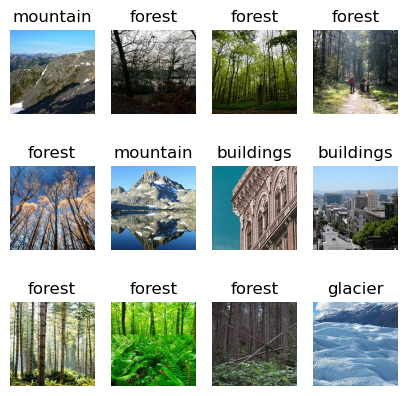

In [27]:
def show_dataset():
  plt.figure(figsize=(5, 5))
  for images, labels in train_ds.take(1):
    for i in range(12):
      ax = plt.subplot(3, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(train_ds.class_names[labels[i]])
      plt.axis("off")

show_dataset()

# Underfitting Model
We will create a model that is too simple and won't describe the data accurately enough.

## Building the Model
We start with a convolutional layer that'll import the images and use the ReLU activation function (we use that activation function for all the convolution and dense layers). Using a saturating activation function (like e.g. hyperbolic tangent tanh) would not be as efficient, but it would not contribute to underfitting. It would only make the model slower. That's why we use the more efficient non-saturating activation function ReLU.

The next layer will run a kernel of $3 \times 3$ over each image, 6 times. `padding=same` is referring to the padding of the image (needed because of the kernel size) being filled with zeros.  We have set the stride of the first convolutional layer to (3, 3). This was needed (for the underfitting model at least) to ensure there are no more than 5000 parameters.
It's similar to downscaling the the images from $150 \times 150px$ to $50 \times 50px$. We did not rescale the images in the beginning, because this way, we are able to preserve the quality of the images within the plots. Furthermore, we did not notice any increase in runtime, each epoch took the same amount of time to calculate (thanks to the GPU acceleration with tensorflow-metal, more on that later).

After that there's a `MaxPooling2D` layer which goes through the feature map (output of the `Conv2D` layer) and only takes the most relevant information.

Following that is another convolution layer and max pooling layer. Next, the image will be flattened into a vector, ready to be fed to the following dense layer. 

The last layer is a dense layer which represents the output layer, having a shared softmax activation layer to determine the probabilities of the 5 different classes.

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(6, (3,3), input_shape=(img_size,img_size,3), activation='relu', padding='same', strides=(3,3)),
    MaxPooling2D(),

    Conv2D(6, (3,3), activation='relu', padding='same'),
    MaxPooling2D(),

    Flatten(),
    Dense(5, activation='softmax')
])
model._name='underfitting_model'

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "underfitting_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 50, 50, 6)         168       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 25, 25, 6)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 25, 25, 6)         330       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 12, 12, 6)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 864)               0         
                                                                 
 dense_1 (Dense)             (None, 5)          

### Dropout?

At first we had some more dense layers in our underfitting model, and we were thinking if we should apply dropout to some of them. This is now no longer relevant (because the current model only has one dense layer), but we wanted to share our findings.

We ended up halfing the amount of nodes of those layers for the underfitting model. Why? We learned that the difference between applying `dropout(0.5)` and halving the nodes of the layer is that dropout randomly drops out nodes (more precisely, it reduces the weights to 0) during each training iteration, which means that **different** nodes will be dropped out in each iteration. This allows the network to learn more robust and generalizable representations of the data, as it is forced to rely on a subset of nodes in each iteration, which prevents overfitting. Each node needs to supply relevant information to the next layer on it's own, as the next layer's node can no longer depend on the combination of information from the previous nodes (because some nodes are not there anymore). Also, dropout is present during training, but not during inference. 

While, on the other hand, halving the nodes reduces the number of nodes in the layer permanently, which means that the network has less capacity to learn and represent complex patterns in the data. This then leads to underfitting, where the model is not able to capture the important features in the data. Which is exactly what we want.

## Training the Model

In [29]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30
)

Epoch 1/30
  1/292 [..............................] - ETA: 1:24 - loss: 41.4968 - accuracy: 0.2188

2023-03-16 09:15:20.004193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


292/292 [==============================] - ETA: 0s - loss: 2.8008 - accuracy: 0.2833

2023-03-16 09:15:23.645037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


292/292 [==============================] - 4s 14ms/step - loss: 2.8008 - accuracy: 0.2833 - val_loss: 1.5476 - val_accuracy: 0.3773
Epoch 2/30
292/292 [==============================] - 4s 14ms/step - loss: 1.4197 - accuracy: 0.3898 - val_loss: 1.3596 - val_accuracy: 0.4155
Epoch 3/30
292/292 [==============================] - 4s 13ms/step - loss: 1.3260 - accuracy: 0.4062 - val_loss: 1.3198 - val_accuracy: 0.4180
Epoch 4/30
292/292 [==============================] - 4s 13ms/step - loss: 1.2768 - accuracy: 0.4205 - val_loss: 1.2685 - val_accuracy: 0.4240
Epoch 5/30
292/292 [==============================] - 4s 13ms/step - loss: 1.2423 - accuracy: 0.4315 - val_loss: 1.2461 - val_accuracy: 0.4356
Epoch 6/30
292/292 [==============================] - 4s 13ms/step - loss: 1.2236 - accuracy: 0.4375 - val_loss: 1.2340 - val_accuracy: 0.4412
Epoch 7/30
292/292 [==============================] - 4s 14ms/step - loss: 1.1999 - accuracy: 0.4441 - val_loss: 1.2237 - val_accuracy: 0.4446
Epoch 8/30

## Visualize and analyze the model
Now, we'll have a look at how well the model performs.

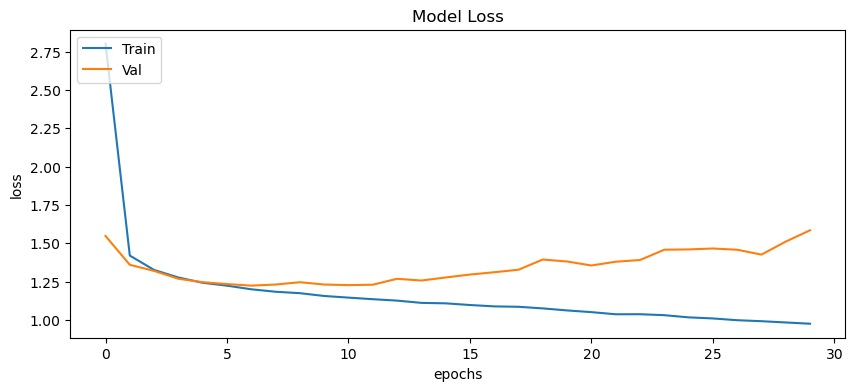

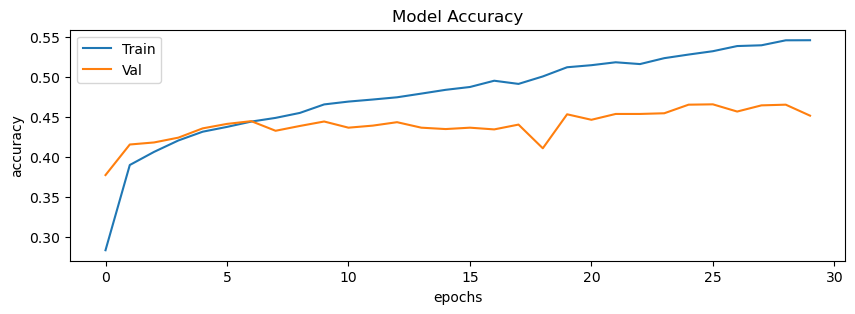

In [30]:
def visualize_loss_and_accuracy():
    # Plot the loss
    plt.figure(figsize=(10,4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['Train','Val'], loc= 'upper left')
    plt.show()

    # Plot the accuracy
    plt.figure(figsize=(10,3))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

visualize_loss_and_accuracy()

We can see from the learning curves that the model slowly converges and that the model therefore is underfitting. Both the training and validation accuracy curves plateau at a low value, indicating that the model is not learning the patterns in the data well enough.

### Make predictions on the test dataset

In [31]:
testing_img_path = "./dataset/seg_test/seg_test/"
seed = 42

# Load the test dataset
test_ds = keras.utils.image_dataset_from_directory(
    testing_img_path,
    labels="inferred",
    label_mode='int',
    seed=seed,
    image_size=(img_size, img_size),
    batch_size=32
)

Found 2499 files belonging to 5 classes.


In [32]:
# Initialize the arrays
true_labels = np.array([], dtype=np.uint8)
pred_labels = np.array([], dtype=np.uint8)
pred_proba = np.array([], dtype=np.uint8)
images = np.array([], dtype=np.uint8)
pred_proba_batch = np.array([], dtype=np.uint8)
pred_proba = np.array([], dtype=np.float32)

# Extract everything out of the dataset
# We need to run all of it in the same for loop, because apparently,
# tf.data.Dataset object streams are shuffled differently each time 😤
for images_batch, true_labels_batch in test_ds:
    pred_proba_batch = model.predict(images_batch)

    # special treatment to initialize the shapes
    if (images.size == 0):
        images = images_batch.numpy() 
    else:
        images = np.concatenate([images, images_batch], axis=0)
    
    if (pred_proba.any()):
        pred_proba = np.concatenate([pred_proba, pred_proba_batch], axis=0)
    else:
        pred_proba = pred_proba_batch

    # pred_labels_batch = np.argmax(pred_proba_batch, axis=-1)
    true_labels = np.concatenate([true_labels, true_labels_batch])
    pred_labels = np.argmax(pred_proba, axis=-1)

1/1 [==============================] - 0s 13ms/step


2023-03-16 09:17:23.037909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 52ms/step


2023-03-16 09:17:30.595459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


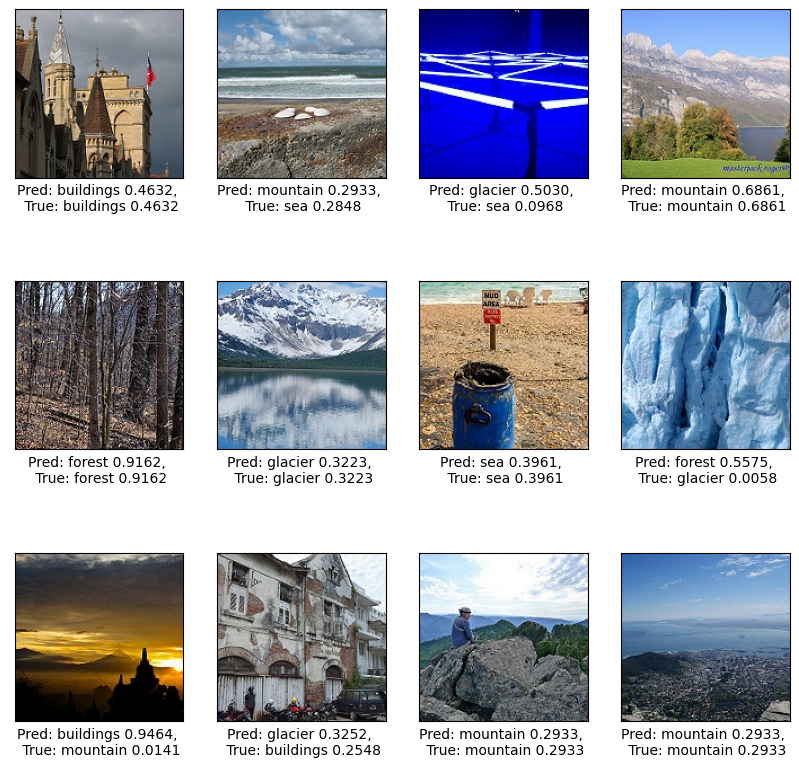

In [33]:
plt.figure(figsize=(10, 10))
for i in range(12):
    ax = plt.subplot(3, 4, i + 1)

    pred_label = test_ds.class_names[pred_labels[i]]
    pred_label_probability = pred_proba[i][pred_labels[i]]

    true_label = test_ds.class_names[true_labels[i]]
    true_label_probability = pred_proba[i][true_labels[i]]

    plt.imshow(images[i].astype("uint8"))
    plt.xlabel(f'Pred: {pred_label} {pred_label_probability:.4f}, \n True: {true_label} {true_label_probability:.4f}')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

plt.show()

### Evaluate the performance of the model

In [34]:
print(f'Accuracy: {model.evaluate(test_ds)[1]}')

79/79 [==============================] - 1s 8ms/step - loss: 1.5672 - accuracy: 0.4446
Accuracy: 0.44457781314849854


### Confusion Matrix
The confusion matrix is another way to visualize the performance of the model and whether it is underfitting or not.

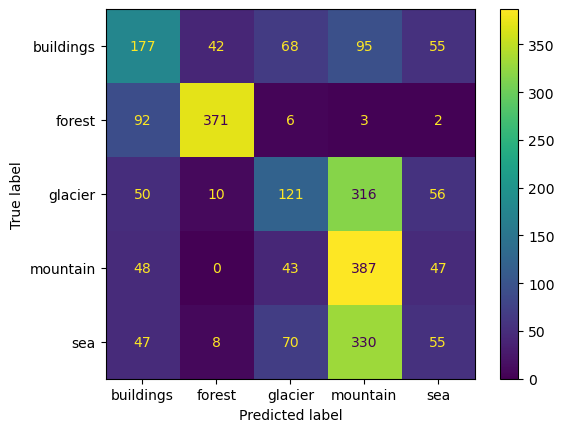

In [35]:
def get_true_and_pred_labels(dataset):
    true_labels = np.array([], dtype=np.uint8)
    pred_labels = np.array([], dtype=np.uint8)
    for images_batch, true_labels_batch in dataset:
        pred_labels_batch = np.argmax(model.predict(images_batch), axis=-1)
        true_labels = np.concatenate([true_labels, true_labels_batch])
        pred_labels = np.concatenate([pred_labels, pred_labels_batch])
    return true_labels, pred_labels

def print_confusion_matrix(true_classes, predicted_classes):
    confusion_matrix = metrics.confusion_matrix(y_true=true_classes, y_pred=predicted_classes)
    display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=test_ds.class_names)
    display.plot()
    plt.show()

# true_labels, pred_labels = get_true_and_pred_labels(test_ds) not needed bc already calculated
print_confusion_matrix(true_labels, pred_labels)

The (kind of) diagonal line shows that the classifier is good at figuring out which classes the images belong to (for the most part), but all the missclassifications (other hits than the diagonal line) suggest that the classifier is far from being 100% accurate, therefore underfitting.

### Classification Report


In [36]:
print('Classification Report:\n', metrics.classification_report(y_true=true_labels, y_pred=pred_labels))

Classification Report:
               precision    recall  f1-score   support

           0       0.43      0.41      0.42       437
           1       0.86      0.78      0.82       474
           2       0.39      0.22      0.28       553
           3       0.34      0.74      0.47       525
           4       0.26      0.11      0.15       510

    accuracy                           0.44      2499
   macro avg       0.46      0.45      0.43      2499
weighted avg       0.45      0.44      0.42      2499



The classification report shows precision, recall, f1-score and support. Looking at the classification report above, for our underfitting model, it seems pretty bad. With a precision (proportion of true positive predictions among all positive predictions) rate low for all classes, same with the recall score, resulting in a low f1-score (mean of precision and recall), it means the model is not good enough for our task.

Support is the number of actual occurrences (images) of a class in the specified dataset. Unbalanced support in the training data may indicate structural weaknesses in the reported results of the classifier and could mean that stratified sampling or rebalancing is needed, which is not the case with our dataset.